## Interface height vs layer thickness gradients

In models with large scale bottom slope changes the bottom layer thickness ends up incorporating this information in it. While this bottom slope probably impacts the eddy fluxes, it does not seem to be the case that this has a first order effect. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-04 22:05:30.661605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 22:05:30.661634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 22:05:30.662951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [4]:
# Experiment
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        #'dhdx_widened',
                                        #'dhdy_widened',
                                        'dedx_middle_widened',
                                        'dedy_middle_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 8*9 + 1, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

In [5]:
experiment_config['num_inputs']

55

In [6]:

#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 1.733376 gb into memory.
load took: 24.0653 seconds
Will load : 0.1733376 gb into memory.
load took: 3.3734 seconds


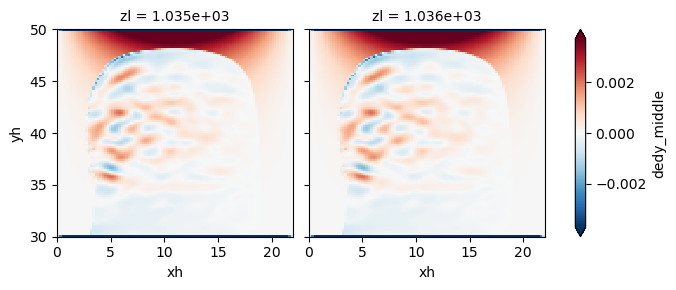

In [7]:
DT.simulation_data['DG']['100'].dedy_middle.isel(Time=-1).plot(col='zl', robust=True)

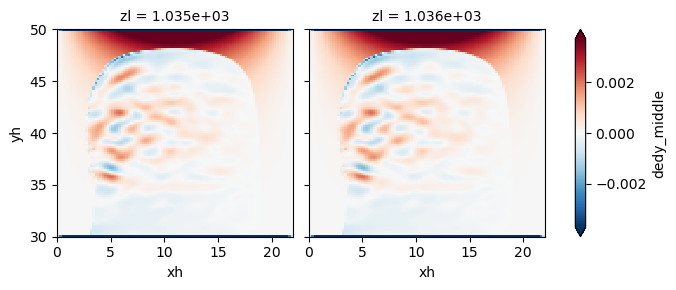

In [50]:
DT.simulation_data['DG']['100'].dedy_middle.isel(Time=-1).plot(col='zl', robust=True)

In [9]:
batch_xr = ML_DT_train.ml_batches[0]

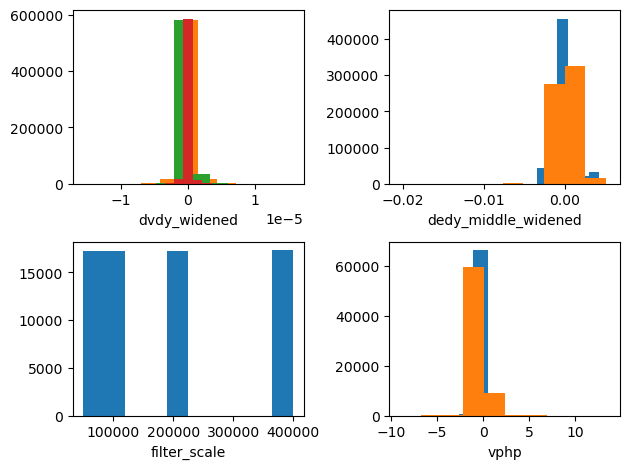

In [10]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [11]:
batch_xr.std()

<xarray.Dataset> Size: 64B
Dimensions:              ()
Data variables:
    dudx_widened         float64 8B 3.877e-07
    dvdx_widened         float64 8B 9.091e-07
    dudy_widened         float64 8B 5.773e-07
    dvdy_widened         float64 8B 3.897e-07
    dedx_middle_widened  float64 8B 0.001258
    dedy_middle_widened  float64 8B 0.001125
    filter_scale         float64 8B 1.341e+05
    uphp                 float32 4B 0.3548
    vphp                 float32 4B 0.5337

In [12]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dedx_middle_widened': ([], 1e-3),
    'dedy_middle_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [13]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [14]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (68937, 55)
Output (y) batch shape: (68937, 2)


In [15]:
num_in = batch_out['X'].shape[-1]
num_in

55

In [16]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [17]:
ANN_model.count_parameters()

3422


In [18]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [ ]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  0.024106711476437143 , Test loss: 0.015782753564417364
At epoch 3. Train loss :  0.009800843718285495 , Test loss: 0.01143618170171976
At epoch 5. Train loss :  0.00842216782070495 , Test loss: 0.010407884046435356
At epoch 7. Train loss :  0.007818401614959175 , Test loss: 0.009728815965354442
At epoch 9. Train loss :  0.007307292818016297 , Test loss: 0.009246006608009338
At epoch 11. Train loss :  0.006920559394701912 , Test loss: 0.008829137496650218
At epoch 13. Train loss :  0.006548703056634278 , Test loss: 0.008279032446444035
At epoch 15. Train loss :  0.006218140655373399 , Test loss: 0.007911117002367973
At epoch 17. Train loss :  0.0059374029420920325 , Test loss: 0.007503724191337824
At epoch 19. Train loss :  0.00571812318033866 , Test loss: 0.007280387729406357
At epoch 21. Train loss :  0.00554568535723799 , Test loss: 0.007132540550082922
At epoch 23. Train loss :  0.005388714133988361 , Test loss: 0.006973825488239526
At epoch 25. Train loss 

Clearly and obviously this loss is a function of the normalization that is used. 

In [64]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [65]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])


In [66]:
# Spin up 
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

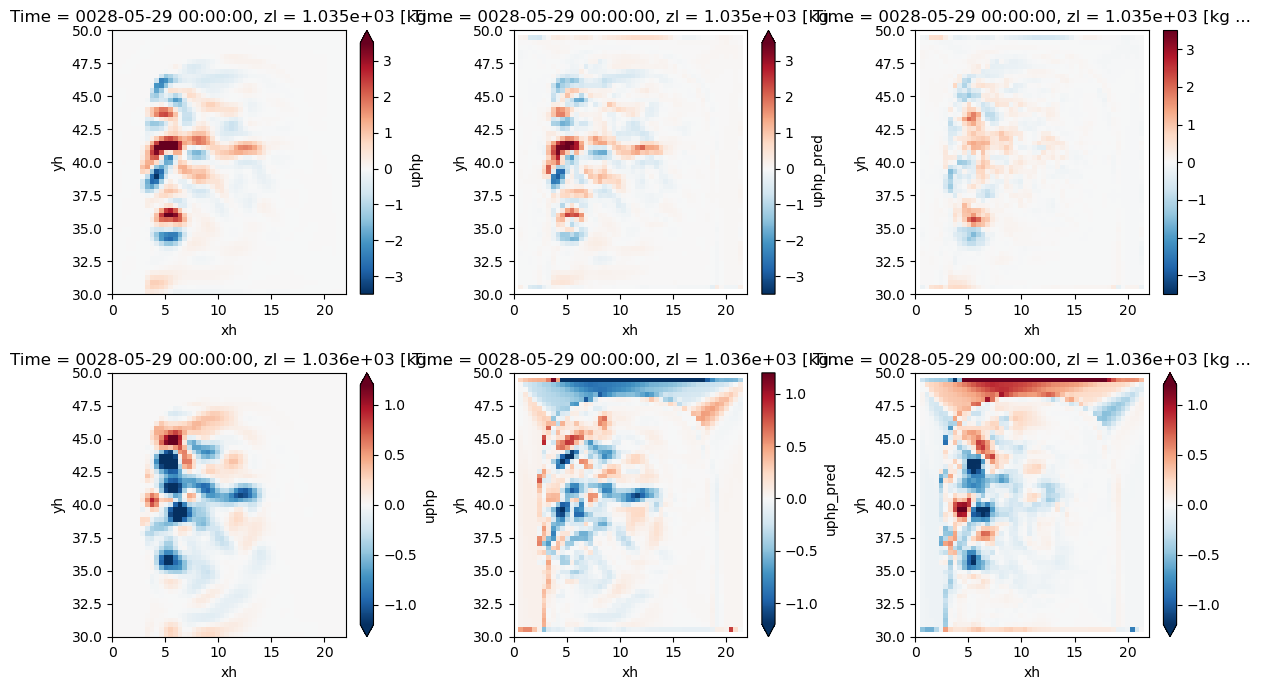

In [67]:
exp = experiment_config['simulation_names'][0]
scale = '200'

plt.figure(figsize=(12, 7))

vmin=-3.5
zl_choice = 0

plt.subplot(231)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(232)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred'].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(233)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred']).isel(Time=0, zl=0).plot(vmin=vmin)


vmin=-1.2 
zl_choice = 1

plt.subplot(234)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(235)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(236)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.tight_layout()

In [26]:
# Pick some region away from boundaries to do that stats 

In [68]:
test_eval.calc_time_hor_space_metrics(yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp',yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])

In [71]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.81011228 0.75859163]
DG 50km, R2 for vphp is (layer:[0,1])[0.84088339 0.73563414]
DG 100km, R2 for uphp is (layer:[0,1])[0.84360129 0.71248022]
DG 100km, R2 for vphp is (layer:[0,1])[0.87902362 0.73218577]
DG 200km, R2 for uphp is (layer:[0,1])[0.7800847  0.57777796]
DG 200km, R2 for vphp is (layer:[0,1])[0.68517406 0.60771612]
DG 400km, R2 for uphp is (layer:[0,1])[0.59995474 0.61808636]
DG 400km, R2 for vphp is (layer:[0,1])[0.4385838  0.35469975]


In [72]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values))
        print(exp+' '+scale+', corr for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values))

DG 50, corr for uphp is (layer:[0,1])[0.91723387 0.89861107]
DG 50, corr for vphp is (layer:[0,1])[0.9352796  0.87563378]
DG 100, corr for uphp is (layer:[0,1])[0.92145528 0.84260037]
DG 100, corr for vphp is (layer:[0,1])[0.93772237 0.85564039]
DG 200, corr for uphp is (layer:[0,1])[0.88362278 0.74371784]
DG 200, corr for vphp is (layer:[0,1])[0.82593959 0.78215792]
DG 400, corr for uphp is (layer:[0,1])[0.77124802 0.74957798]
DG 400, corr for vphp is (layer:[0,1])[0.53701494 0.59645853]


In [24]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', R2 for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+', R2 for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

DG 50, R2 for uphp is [0.70192167 0.60855438]
DG 50, R2 for vphp is [0.65977634 0.43067083]
DG 100, R2 for uphp is [0.79598482 0.51705361]
DG 100, R2 for vphp is [0.78039784 0.57871463]
DG 200, R2 for uphp is [0.76950102 0.46607727]
DG 200, R2 for vphp is [0.66287939 0.52810765]
DG 400, R2 for uphp is [0.61908327 0.56835334]
DG 400, R2 for vphp is [0.41232279 0.24914097]


In [25]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values))
        print(exp+' '+scale+', corr for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values))

DG 50, corr for uphp is [0.87071838 0.81082214]
DG 50, corr for vphp is [0.84869956 0.76134763]
DG 100, corr for uphp is [0.8919992  0.72329992]
DG 100, corr for vphp is [0.88471719 0.76465405]
DG 200, corr for uphp is [0.87665484 0.64796012]
DG 200, corr for vphp is [0.82057495 0.72779364]
DG 400, corr for uphp is [0.76615327 0.68904841]
DG 400, corr for vphp is [0.51884333 0.52130305]


In [26]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', mse for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values))
        print(exp+' '+scale+', mse for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values))

DG 50, mse for uphp is [0.02471782 0.01546896]
DG 50, mse for vphp is [0.04055041 0.02687258]
DG 100, mse for uphp is [0.05180349 0.04501214]
DG 100, mse for vphp is [0.09298881 0.05174112]
DG 200, mse for uphp is [0.0678222  0.05552641]
DG 200, mse for vphp is [0.11158357 0.07066557]
DG 400, mse for uphp is [0.04248629 0.02660162]
DG 400, mse for vphp is [0.05123057 0.04926057]


Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 